# Test bed for python scripts

In [1]:
import os

import pandas as pd
import numpy as np

df = pd.read_csv(os.path.join("data", 
                              "XY_CoMPARA_CDKPaDELFP_filtered2.csv"
                             ), index_col=0)
label_start=2
feat_start=8

In [2]:
from CoMPARA_experiment_helper import load_data

In [6]:
r= load_data()

labels= r['labels']
train_features = r['train_features']
test_features = r['test_features']
train_targets=r['train_targets']
test_targets=r['test_targets']
Fweights_train=r['Fweights_train']
Fweights_test=r['Fweights_test']

In [37]:
from sklearn.metrics import confusion_matrix
def get_cm(y_true, y_pred):
  ind=np.isfinite(y_true.astype(np.float))
  return confusion_matrix(y_true[ind].astype(np.int32), y_pred[ind])

def get_sn_sp(cm):
  tn, fp, fn, tp = cm.ravel()
  sn = np.float(tp)/(tp+fn)
  sp = np.float(tn)/(tn+fp)
  return sn, sp

def model_eval(model, 
	X, y, target_scaler, model_name, label, thresh=None, split_name="Train",
):
	predict = model.predict(X)
	if target_scaler is not None:
		predict = target_scaler.inverse_transform(predict).flatten()

	if thresh is None:
		thresh=0.5
	predict = (predict>thresh).ravel().astype(int)
	cm=get_cm(y, predict)
	sn, sp = get_sn_sp(cm)

	results=[
		[model_name, label, "NER", split_name, np.mean([sn, sp])],
		[model_name, label, 'Sensitivity', split_name, sn], 
		[model_name, label, 'Specificity', split_name, sp]
	]
	return results, sn, sp

In [50]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
idx=4
valid_train_ind = np.where(~np.isnan(train_targets.iloc[:, idx]))[0]
valid_test_ind = np.where(~np.isnan(test_targets.iloc[:, idx]))[0]
y_train = train_targets.iloc[valid_train_ind, idx].values.astype(int)
y_test = test_targets.iloc[valid_test_ind, idx].values.astype(int)
train_sample_weight = compute_sample_weight("balanced", y_train)

clf = xgb.XGBClassifier(n_estimators=499, 
                        use_label_encoder=False,
                        objective="reg:logistic",
                        seed=42
                       )
clf.fit(train_features.iloc[valid_train_ind,:], 
        y_train, 
        sample_weight = train_sample_weight)


In [44]:
from CoMPARA_experiment_helper import model_score
r_train, sn_train, sp_train = model_eval(
    clf,
    train_features.iloc[valid_train_ind, :],
    y_train,
    target_scaler=None,
    model_name="xgboost",
    label=labels[idx],
)
r_test, sn_test, sp_test = model_eval(
    clf,
    test_features.iloc[valid_test_ind, :],
    y_test,
    target_scaler=None,
    model_name="xgboost",
    label=labels[idx],
)

In [45]:
model_score(sn_train, sp_train, sn_test, sp_test, 
            model_name="xgboost", 
            label=labels[idx]
           )

[['xgboost', 'BindingClass', 'Model Score', 'TrainTest', 0.7185997187749942]]

In [46]:
r_train

[['xgboost', 'BindingClass', 'NER', 'Train', 1.0],
 ['xgboost', 'BindingClass', 'Sensitivity', 'Train', 1.0],
 ['xgboost', 'BindingClass', 'Specificity', 'Train', 1.0]]

In [47]:
r_test

[['xgboost', 'BindingClass', 'NER', 'Train', 0.6576201656389484],
 ['xgboost', 'BindingClass', 'Sensitivity', 'Train', 0.33185840707964603],
 ['xgboost', 'BindingClass', 'Specificity', 'Train', 0.9833819241982508]]

# Load tensorflow models

In [2]:
from CoMPARA_experiment_helper import model_score

In [ ]:
sn_train, sp_train, sn_test, sp_test = 0.95,0.99,0.74,0.97 

In [1]:
import time
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.backend.set_floatx('float32')

import os
import numpy as np

In [2]:
from CoMPARA_experiment_helper import load_data
r= load_data()

labels= r['labels']
train_features = r['train_features']
test_features = r['test_features']
train_targets=r['train_targets']
test_targets=r['test_targets']
Fweights_train=r['Fweights_train']
Fweights_test=r['Fweights_test']

In [3]:
model_type="dense"
checkpoint_path=os.path.join(
    "CoMPARA_multiclass_labels",
    f"210519_{model_type}_lr0_001",
    f"210519_{model_type}_lr0_001_CoMPARA_multiclass_Potency_Class_Agonist",
    "model_checkpoint"
)
idx=1


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from CoMPARA_experiment_helper import data_scaling
from CoMPARA_experiment_helper import get_model_setup_params, get_model_compile_params, get_model

label=labels[idx]
valid_train_ind = np.where(~np.isnan(train_targets.iloc[:, idx]))[0]
valid_test_ind = np.where(~np.isnan(test_targets.iloc[:, idx]))[0]
train_target = train_targets.iloc[valid_train_ind, idx]
test_target = test_targets.iloc[valid_test_ind, idx]
num_classes=5

feature_scaler=StandardScaler()
target_scaler = MinMaxScaler()

train_features_scaled, test_features_scaled, y_train, y_test, feature_scaler, target_scaler = data_scaling(
            feature_scaler, target_scaler, train_features, test_features, train_target, test_target
        )
if model_type=="LSwFW":
    X_train = np.hstack([train_features_scaled[valid_train_ind,:], Fweights_train[valid_train_ind,:]])
    X_test = np.hstack([test_features_scaled[valid_test_ind,:], Fweights_test[valid_test_ind,:]])
elif model_type=="LSwFW_ones":
    X_train = np.hstack([train_features_scaled[valid_train_ind,:], 
        np.ones_like(train_features_scaled[valid_train_ind,:])])
    X_test = np.hstack([test_features_scaled[valid_test_ind,:], 
        np.ones_like(test_features_scaled[valid_test_ind,:])])
else:
    X_train = train_features_scaled[valid_train_ind,:]
    X_test = test_features_scaled[valid_test_ind,:]
    
# Get model parameters
learning_rate = 0.001
model_setup_params = get_model_setup_params()
model_compile_params = get_model_compile_params(learning_rate)
n_feat = train_features_scaled.shape[1]
model_setup_params['n_feat'] = n_feat
model_compile_params['loss'] = tf.keras.losses.MeanSquaredError()
model_compile_params['metrics'] = [tf.keras.metrics.RootMeanSquaredError()]
# model_setup_params['kernel_initializer']=tf.keras.initializers.HeNormal()

model = get_model(model_type, **model_setup_params)
model.compile(**model_compile_params)

model.load_weights(checkpoint_path)

First dense layer with 1200 hidden unites


In [20]:
import CoMPARA_experiment_helper
from importlib import reload
reload(CoMPARA_experiment_helper)

<module 'CoMPARA_experiment_helper' from 'D:\\Envs\\LocallyLinearManifold\\locally-linear-manifold\\1_Notebooks\\CoMPARA\\CoMPARA_experiment_helper.py'>

In [21]:
results_train, sn_train, sp_train = CoMPARA_experiment_helper.model_eval(model, X_train, train_target.astype(int), target_scaler, model_name = model_type, label=label, split_name="train", num_classes=num_classes)

In [22]:
results_test, sn_test, sp_test = CoMPARA_experiment_helper.model_eval(
    model,
    X_test,
    test_target.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Test",
    num_classes=num_classes

)

In [23]:
results_train


[['dense', 'Potency_Class_Agonist', 'NER', 'train', 0.5],
 ['dense', 'Potency_Class_Agonist', 'Sensitivity', 'train', 0.25],
 ['dense', 'Potency_Class_Agonist', 'Specificity', 'train', 0.75]]

In [24]:
results_test

[['dense', 'Potency_Class_Agonist', 'NER', 'Test', 0.5],
 ['dense', 'Potency_Class_Agonist', 'Sensitivity', 'Test', 0.2],
 ['dense', 'Potency_Class_Agonist', 'Specificity', 'Test', 0.8]]

In [25]:
from CoMPARA_experiment_helper import model_score
results_modelscore = model_score(sn_train, sp_train, sn_test, sp_test,
                                 model_name=model_type,
                                 label=label,
                                 )

In [26]:
results_modelscore


[['dense',
  'Potency_Class_Agonist',
  'Model Score',
  'TrainTest',
  0.6114999999999999]]

In [29]:
results_train, sn_train, sp_train = CoMPARA_experiment_helper.model_eval(model, X_train, train_target.astype(int), target_scaler, model_name = model_type, label=label, split_name="train", num_classes=num_classes)

In [30]:
results_test, sn_test, sp_test = CoMPARA_experiment_helper.model_eval(
    model,
    X_test,
    test_target.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Test",
    num_classes=num_classes

)

In [ ]:
test_predict = target_scaler.inverse_transform(model(X_test))

In [31]:
results_train

[['dense', 'Potency_Class_Agonist', 'NER', 'train', 0.5],
 ['dense', 'Potency_Class_Agonist', 'Sensitivity', 'train', 0.25],
 ['dense', 'Potency_Class_Agonist', 'Specificity', 'train', 0.75]]

In [32]:
results_test

[['dense', 'Potency_Class_Agonist', 'NER', 'Test', 0.5],
 ['dense', 'Potency_Class_Agonist', 'Sensitivity', 'Test', 0.2],
 ['dense', 'Potency_Class_Agonist', 'Specificity', 'Test', 0.8]]

In [34]:
results_modelscore

[['dense',
  'Potency_Class_Agonist',
  'Model Score',
  'TrainTest',
  0.6114999999999999]]

In [2]:
checkpoint_path=os.path.join(
    "CoMPARA_singlelabelmodels",
    "210429_LS_lr0_005",
    "210429_LS_lr0_005_CoMPARA_binary_BindingClass", 
    "model_checkpoint"
)
model_type="LS"

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from CoMPARA_experiment_helper import data_scaling

feature_scaler=StandardScaler()
target_scaler = None

idx=4
valid_train_ind = np.where(~np.isnan(train_targets.iloc[:, idx]))[0]
valid_test_ind = np.where(~np.isnan(test_targets.iloc[:, idx]))[0]
train_target = train_targets.iloc[valid_train_ind, idx]
test_target = test_targets.iloc[valid_test_ind, idx]

train_features_scaled, test_features_scaled, y_train, y_test, feature_scaler, target_scaler = data_scaling(
            feature_scaler, target_scaler, train_features, test_features, train_target, test_target
        )

train_sample_weight = compute_sample_weight("balanced", y_train)
if model_type=="LSwFW_ones":
    Fweights_train = np.ones_like(train_features_scaled)
    Fweights_test = np.ones_like(test_features_scaled)
if model_type=="LSwFW" or model_type=="LSwFW_ones":
    X_train = np.hstack([train_features_scaled[valid_train_ind,:],
                         Fweights_train[valid_train_ind,:]
                        ])
    X_test = np.hstack([test_features_scaled[valid_test_ind,:],
                        Fweights_test[valid_test_ind,:]
                       ])
else:
    X_train = train_features_scaled[valid_train_ind,:]
    X_test = test_features_scaled[valid_test_ind,:]

In [5]:
from CoMPARA_experiment_helper import get_model_setup_params, get_model_compile_params
model_setup_params=get_model_setup_params()
model_setup_params['n_feat'] = train_features.shape[1]
model_compile_params = get_model_compile_params(0.005)

from CoMPARA_experiment_helper import _get_model
tf_model = _get_model(model_type, **model_setup_params)

tf_model.load_weights(checkpoint_path)

In [6]:
train_predict=tf_model(X_train).numpy().ravel()

(array([746., 372., 165.,  90.,  46.,  29.,  30.,  30.,  50., 104.]),
 array([0.01380246, 0.11058144, 0.20736042, 0.3041394 , 0.40091836,
        0.49769735, 0.59447634, 0.69125533, 0.78803426, 0.88481325,
        0.98159224], dtype=float32),
 <BarContainer object of 10 artists>)

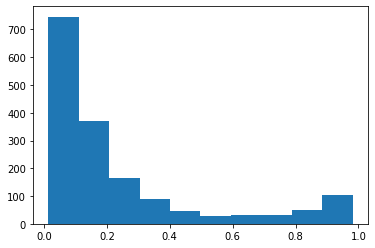

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_predict)

(array([1428.,  820.,  574.,  343.,  203.,  140.,   89.,   89.,   94.,
         102.]),
 array([0.01490827, 0.11304371, 0.21117914, 0.30931458, 0.40745002,
        0.50558543, 0.6037209 , 0.7018563 , 0.7999917 , 0.8981272 ,
        0.9962626 ], dtype=float32),
 <BarContainer object of 10 artists>)

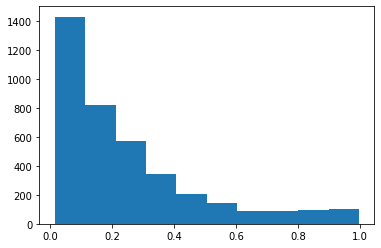

In [8]:
test_predict = tf_model(X_test).numpy().ravel()
plt.hist(test_predict)

In [9]:
from CoMPARA_experiment_helper import model_eval, model_score

label=labels[idx]

results_train, sn_train, sp_train = model_eval(
    tf_model,
    X_train,
    y_train.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Train"
)
results_test, sn_test, sp_test = model_eval(
    tf_model,
    X_test,
    test_target.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Test"
)
results_modelscore = model_score(sn_train, sp_train, sn_test, sp_test,
                                 model_name=model_type,
                                 label=label,
                                 )

In [10]:
results_train

[['LS', 'BindingClass', 'NER', 'Train', 0.9702972346414969],
 ['LS', 'BindingClass', 'Sensitivity', 'Train', 0.9747474747474747],
 ['LS', 'BindingClass', 'Specificity', 'Train', 0.9658469945355191]]

In [11]:
results_test

[['LS', 'BindingClass', 'NER', 'Test', 0.7428668180293609],
 ['LS', 'BindingClass', 'Sensitivity', 'Test', 0.5641592920353983],
 ['LS', 'BindingClass', 'Specificity', 'Test', 0.9215743440233236]]

In [12]:
results_modelscore

[['LS', 'BindingClass', 'Model Score', 'TrainTest', 0.8068557875634831]]

## Load dense model

In [13]:
checkpoint_path=os.path.join(
    "CoMPARA_singlelabelmodels",
    "210429_dense_lr0_005",
    "210429_dense_lr0_005_CoMPARA_binary_BindingClass", 
    "model_checkpoint"
)
model_type="dense"

tf_model2 = _get_model(model_type, **model_setup_params)

tf_model2.load_weights(checkpoint_path)

train_predict2=tf_model2(train_features_scaled[valid_train_ind]).numpy().ravel()
test_predict2 = tf_model2(test_features_scaled[valid_test_ind]).numpy().ravel()

results_train2, sn_train2, sp_train2 = model_eval(
    tf_model2,
    train_features_scaled[valid_train_ind],
    y_train.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Train"
)
results_test2, sn_test2, sp_test2 = model_eval(
    tf_model2,
    test_features_scaled[valid_test_ind],
    test_target.astype(int),
    target_scaler,
    model_name=model_type,
    label=label,
    split_name="Test"
)
results_modelscore2 = model_score(sn_train2, sp_train2, sn_test2, sp_test2,
                                 model_name=model_type,
                                 label=label,
                                 )
print(results_train2, results_test2, results_modelscore2)

First dense layer with 1200 hidden unites
[['dense', 'BindingClass', 'NER', 'Train', 0.9114402218910416], ['dense', 'BindingClass', 'Sensitivity', 'Train', 0.9191919191919192], ['dense', 'BindingClass', 'Specificity', 'Train', 0.9036885245901639]] [['dense', 'BindingClass', 'NER', 'Test', 0.740269356794551], ['dense', 'BindingClass', 'Sensitivity', 'Test', 0.6061946902654868], ['dense', 'BindingClass', 'Specificity', 'Test', 0.8743440233236152]] [['dense', 'BindingClass', 'Model Score', 'TrainTest', 0.8191991122362743]]


In [14]:
train_predict_averaged = np.average([train_predict, train_predict2],
                                    axis=0)
test_predict_averaged = np.average([test_predict, test_predict2], 
                                   axis=0)

In [15]:
from CoMPARA_experiment_helper import get_cm, get_sn_sp
def model_eval_(predict, y):
    predict = (predict>0.5).ravel().astype(int)
    cm = get_cm(y, predict)
    sn, sp = get_sn_sp(cm)
    return np.mean([sn, sp]), sn, sp

ner_train, sn_train_ave, sp_train_ave = model_eval_(
    train_predict_averaged, y_train.astype(int))
ner_test, sn_test_ave, sp_test_ave = model_eval_(test_predict_averaged,
                                        y_test.astype(int))
results_modelscore_averaged = model_score(sn_train_ave, sp_train_ave, sn_test_ave, sp_test_ave,
                                 model_name=model_type,
                                 label=label,
                                 )

In [16]:
print(results_modelscore_averaged)

[['dense', 'BindingClass', 'Model Score', 'TrainTest', 0.8107716141643768]]


# Visualize attentions

In [35]:
train_attentions=tf_model.layers[1](X_train)
test_attentions=tf_model.layers[1](X_test)


In [40]:
from sklearn.manifold import TSNE
dr = TSNE(n_components=2)
embed=dr.fit_transform(np.vstack([train_attentions, test_attentions]))


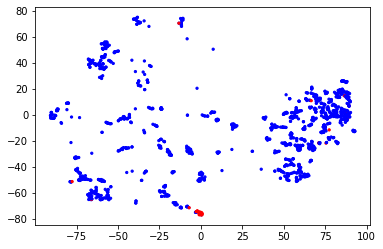

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
n_train=X_train.shape[0]
plt.scatter(embed[:n_train, 0], embed[:n_train,1], s= 5, c=y_train, label="train", cmap="bwr")


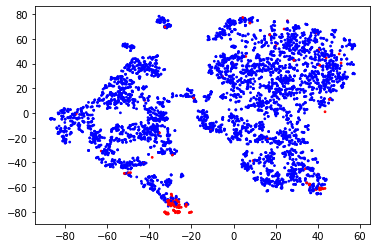

In [55]:
plt.scatter(embed[n_train:, 0], 
            embed[n_train:,1], 
            s=3, c=y_test, cmap="bwr",
            label="test")

In [56]:
dense_checkpoint_path=os.path.join(
    "CoMPARA_singlelabelmodels",
    "210429_dense_lr0_005",
    "210429_dense_lr0_005_CoMPARA_binary_AgonistClass", 
    "model_checkpoint"
)
from CoMPARA_experiment_helper import get_attention_model, get_dense_model, get_attentionwFW_model
dense_model = get_dense_model(**model_setup_params)

dense_model.load_weights(dense_checkpoint_path)

First dense layer with 1200 hidden unites


In [57]:
train_firstdense=dense_model.layers[1](train_features_scaled[valid_train_ind])
test_firstdense=dense_model.layers[1](test_features_scaled[valid_test_ind])
from sklearn.manifold import TSNE
dr = TSNE(n_components=2)
embed=dr.fit_transform(np.vstack([train_firstdense, test_firstdense]))


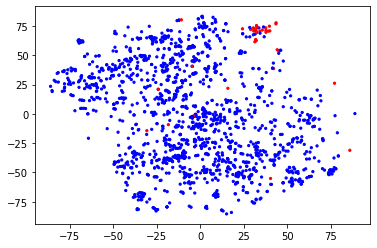

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
n_train=train_firstdense.shape[0]
plt.scatter(embed[:n_train, 0], embed[:n_train,1], s= 5, c=y_train, label="train", cmap="bwr")


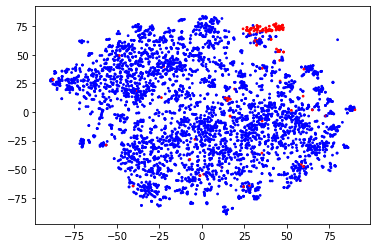

In [59]:
plt.scatter(embed[n_train:,0], 
            embed[n_train:,1], 
            s=3, c=y_test, cmap="bwr",
            label="test")

In [60]:
LS_checkpoint_path=os.path.join(
    "CoMPARA_singlelabelmodels",
    "210429_LS_lr0_005",
    "210429_LS_lr0_005_CoMPARA_binary_AgonistClass", 
    "model_checkpoint"
)
from CoMPARA_experiment_helper import get_attention_model, get_dense_model, get_attentionwFW_model
LS_model = get_attention_model(**model_setup_params)

LS_model.load_weights(LS_checkpoint_path)

In [61]:
train_att=LS_model.layers[1](train_features_scaled[valid_train_ind])
test_att=LS_model.layers[1](test_features_scaled[valid_test_ind])
from sklearn.manifold import TSNE
dr = TSNE(n_components=2)
embed=dr.fit_transform(np.vstack([train_att, test_att]))


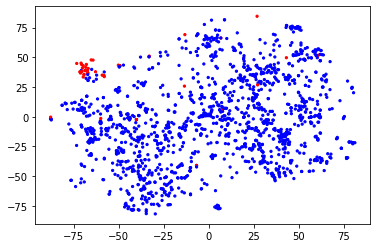

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
n_train=train_firstdense.shape[0]
plt.scatter(embed[:n_train, 0], embed[:n_train,1], s= 5, c=y_train, label="train", cmap="bwr")


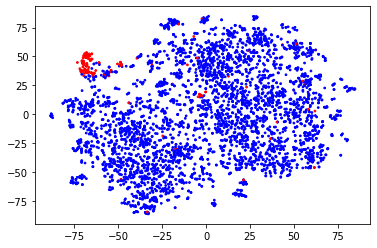

In [63]:
plt.scatter(embed[n_train:,0], 
            embed[n_train:,1], 
            s=3, c=y_test, cmap="bwr",
            label="test")

## Evaluate and save metric scores

In [178]:
from CoMPARA_experiment_helper import file_updater
csv_summary_path = os.path.join("CoMPARA_singlelabelmodels",
                                f"210429_{model_type}.csv"
                               )
# header = [["Model", "Label", "Metric", "Split", "Score"]]
# file_updater(csv_summary_path, header, mode='w')
file_updater(csv_summary_path, results_train, mode='a')
file_updater(csv_summary_path, results_test, mode='a')
file_updater(csv_summary_path, results_modelscore, mode='a')

In [179]:
results_modelscore

[['LS', 'BindingClass', 'Model Score', 'TrainTest', 0.8068557875634831]]

In [180]:
results_train

[['LS', 'BindingClass', 'NER', 'Train', 0.9702972346414969],
 ['LS', 'BindingClass', 'Sensitivity', 'Train', 0.9747474747474747],
 ['LS', 'BindingClass', 'Specificity', 'Train', 0.9658469945355191]]

In [181]:
results_test

[['LS', 'BindingClass', 'NER', 'Test', 0.7428668180293609],
 ['LS', 'BindingClass', 'Sensitivity', 'Test', 0.5641592920353983],
 ['LS', 'BindingClass', 'Specificity', 'Test', 0.9215743440233236]]

# Get model score for consensus model

In [182]:
csv_summary_path = os.path.join("consensus_model_score.csv")
header = [["Model", "Label", "Metric", "Split", "Score"]]
file_updater(csv_summary_path, header, mode='w')

sn_train, sp_train, sn_test, sp_test = 0.95, 0.99, 0.74, 0.97
results_modelscore = model_score(sn_train, sp_train, sn_test, sp_test, 
                                 model_name="CoMPARA Consensus", 
                                 label="Agonist"
                                )
file_updater(csv_summary_path, results_modelscore, mode='a')

In [183]:
sn_train, sp_train, sn_test, sp_test = 1.00, 0.96, 0.61, 0.87
results_modelscore = model_score(sn_train, sp_train, sn_test, sp_test, 
                                 model_name="CoMPARA Consensus", 
                                 label="Antagonist"
                                )
file_updater(csv_summary_path, results_modelscore, mode='a')

In [184]:
sn_train, sp_train, sn_test, sp_test = 0.98, 0.96, 0.65, 0.90
results_modelscore = model_score(sn_train, sp_train, sn_test, sp_test, 
                                 model_name="CoMPARA Consensus", 
                                 label="Binding"
                                )
file_updater(csv_summary_path, results_modelscore, mode='a')